

Here, I design a Denoising Autoencoder. I add a gaussian noise to inputs and then design an autoencoder to denoise the picture and reconstruct the original (clean) image. Thus, the goal is to minimize difference between original image and reconstructed image. The noise factor will help us to reduce overfitting (maybe identification map) and improving the generalization of the task.

The dataset I use here is about 500 random pictures of dogs from Cat vs Dog dataset. I also used 150 others for evaluation.

To have a richer dataset, I could have used data augmentation (as I did in a small project before in retinal image segmentation) to produce more images. However, I ignored it as it was a little demanding  and also, our dataset is rich enough for this task.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import copy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [ ]:
"""
As we need 600* 600 grayscale images in tensor format, I defined a transformer that fulfills our need.
Furthermore, I also normalized tensors to normal distribution N(.485, .229), where .485 is mean and the variance is .229.
Normalization is generally done to get the data into a range and reduces the skewness which helps learn faster and better.
"""
tfms= transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize([.485], [.229]),
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing our datasets from drive and transform data
train_ds= datasets.ImageFolder(root='/content/drive/MyDrive/Dogs/train', transform= tfms)
test_ds= datasets.ImageFolder(root='/content/drive/MyDrive/Dogs/test', transform= tfms)

In [ ]:
print(len(train_ds), len(test_ds))

500 150


In [ ]:
#defining dataloader to feed our neural networks in group of 8 images. As I want to demonstrate performance of
#the autoencoder during training, I also shuffled test set as well to see different picture rather than only a few in training.
train_loader= torch.utils.data.DataLoader(train_ds, batch_size= 8, shuffle= True)
test_loader= torch.utils.data.DataLoader(test_ds, batch_size= 8, shuffle= True)

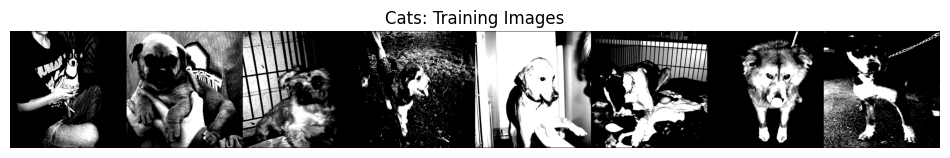

In [ ]:
# Load a batch of images into memory
images = next(iter(train_loader))[0]
images = make_grid(
    images.view(8, 1, 600, 600),             #8 is batch_size and 1 is input channels which are 1 as our inputs are grayscale
    padding=2,
).cpu()

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Cats: Training Images")
plt.imshow(np.transpose(images, (1, 2, 0)))  #We need transpose as in torch, we have (batch, (channels= 1 for grayscale, M, N))
                                             #But in matplotlib, we need pillow images i.e. (batch, ( M, N, channels)) shape.
plt.show()



In [ ]:
#Here, we define a class to add random (gaussian distribution) noises to each image before giving it to autoencoder.
#It produces a picture (same shape as our image) with pixels from a normal distribution N(.5, .5). Then, adds it to our image.

normal = torch.distributions.Normal(0.5, 0.5)
class AdditiveGaussianNoise(nn.Module):
    def __init__(self, plot=False):
        super().__init__()
        self.plot = plot

    def forward(self, x):

        if self.training or self.plot:
            device = x.device
            return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)
        else:
            return x

In this part, firstly, I want to talk about two important techniques in NNs: BatchNormalization and Activation Functions.

**BatchNormalization**: As in training, by updating parameters of each layer, the distibution of its outputs will be distorted, a technique called batch normalization is used to minimize the shift of the covariance of output of each layer before feeding to the next layer. This techinque accelerate the convergence of the network.

**ReLU (Rectified linear unit)**: As neural networks are made of percprtons which are in the linear form of WX+b, they can not learn complex shapes. Based on Universal approximation theorem, two-layer neural network using a non-linear activation function can approximate any function. That is why we need activation functions. ReLU is most used and probably most successful activation function which is used in hidden layers of neural networks because of its excellent power to tackle *vanishing gradient* which is very common problem in deep neural networks.

Now, as I want to do both batch normalization and ReLU activation function reguarly in my autoencoder, I defined
a class that do both for me.

In [ ]:
class batch_norm(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.bn= nn.BatchNorm2d(in_c)
        self.relu= nn.ReLU()

    def forward(self, input):
        x= self.bn(input)
        x= self.relu(x)
        return x


In this section, I defined my **AutoEncoder** network. I used 4 Convolutional layers and a MaxPooling as **Encoding** and 5 ConvTranspose as **Decoding**. Firstly, I briefly explain these elements.

**Convolutional layers**: Convolutional layers are actually filter masks of weights that stride over our inputs to extract general features like maybe edges, colors, corners in first layers and most advanced features like maybe eyes, ears etc in last layers, locally. Here, as we work with images, we use Conv2d. Each convolution layer mainly has:

in_channels and out_channels: these are number of input and output filter masks. Each out_channels should be the same size of next convolution layers in_channels. 64 out_channels means that we use 64 filter masks of our kernel_size. In defining Convolutions, 1th and 2th numbers are for in_channels and out_channels respectively, by default.

 kernel_size: which is the size of our filter masks (weights). Thus, kernel_size of 5 means a 5*5 filter mask (in Conv2d in our case) that stride over image to extract features by updating weights. In defining Convolutions, 3th number used for kernel_size by default.

 stride: this is step size for out filter masks. It means that if stride=2, our filters move towards right and then down, two pixels in each movements.

  padding: padding is the process of adding extra pixels (most commonly 0) to the input image before applying convolution. Acting as a protective boundary around the image, these additional pixels allow the network to retain more spatial information by considering border pixels more than one time, so, like other pixels. Moreover, padding determines the output size of each layer in the CNN. Otherwise, each convolution will progressively reduce the spatial dimensions of the feature maps, resulting in a significant downsampling. So, it also controls the output size of each layer.

 **MaxPooling layer**: Pooling layers are used to reduce the dimensions of the feature maps. Thus, they reduce the number of parameters to learn and the amount of computation performed in the network. We can say that the pooling layer summarises the features present in a region of the feature map generated by a convolution layer. Most successful Pooling layer is MaxPooling which selects the maximum element from the region of the feature map covered by the filter. Thus, the output after max-pooling layer would be a feature map containing the most prominent features of the previous feature map. Also, by reducing number of parameters and ignoring not important features, it reduces overfitting, logically.

 As a drawback, ignoring other elements causes **loss of informations**. Therefore, it is not usually used after each single layer. *That is why I used it once after second convolution layer.*

 **ConvTranspose2d**: It is an upsampling layer that generates the output feature map greater than the input feature map. It is widely used as Decoder in Autoencoders. Conv2d and a ConvTranspose2d are initialized with same parameters, they are inverses of each other in regard to the input and output shapes.

 output_padding: When stride > 1, Conv2d maps multiple input shapes to the same output shape. output_padding is provided to resolve this ambiguity by effectively increasing the calculated output shape on one side.

Other important parameters are same as Conv2d.

 **Remark 1**: There is no restriction in choosing number of encoding and decoding layers. As experience showed, deeper network does not gaurantee better performance. As a matter of fact, deeper network can not only results in overfitting but also even underfitting due to vanishing gradiant and if we want to use very deep network, we should use skip connections reguarly between layers to reduce vanishing gradiant.

 **Remark 2**: Kernel size, stride size, number of channels, number of encoding and decoding layers and different activation functions are all hyper-parameters and changing them results in different results. Also, we should be careful about number of parameters as increasing number of parameters by e.g. deepening the network or increasing number of filters can result in overfitting due to too much complexity.

 **Remark 3**: There is no need that number of encoding layer and decoding layers be the same as long as the output of network is the same size as input.

**Remark 4**: Why we increase the number of filters as we go deeper? As we go deeper, we get more advanced and important features of our image by combinig earlier features from previous layer filters. As last layers extract most important specific features like e.g. eyes, we need more available filters for combination.

In [ ]:

class AutoEncoder(nn.Module):
    def __init__(self):

        super().__init__()

        #encoder
        self.noise= AdditiveGaussianNoise()                            #adding gaussian noise to inputs

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            batch_norm(64),
        )

        self.conv2= nn.Sequential(nn.Conv2d(64, 192, kernel_size=5, stride=2, padding=1),
            batch_norm(192),
        )
        self.pool2= nn.MaxPool2d(2, 2)  #As I said before, I used maxpooling only once as using it a lot, will cause loss
                                        #of information. (2, 2) are the (kernel_size, stride).

        self.conv3= nn.Sequential(nn.Conv2d(192, 512, kernel_size=3, stride=2, padding=1),
            batch_norm(512),
        )

        self.conv4= nn.Sequential(nn.Conv2d(512, 1024, kernel_size=5, stride=2, padding=1),
            batch_norm(1024),
        )

        #DECODER

        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            batch_norm(512),
        )

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size= 3, stride=2),
            batch_norm(512),)

        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(512, 192, kernel_size= 5, stride=2, padding=1, output_padding=1),
            batch_norm(192),

        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(192, 64, kernel_size=5, stride=2, padding=1, output_padding=1),
            batch_norm(64),
        )

        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=0, output_padding=1),
            nn.Sigmoid(),             # As we need our outputs to be tensors between [0,1], we use sigmoid to do it for us.
        )                             # Sigmoid is an activation function that project outputs non-linearly to [0,1]


    def forward(self, inputs):

        #encoder
        x= self.noise(inputs)
        x1 = self.conv1(x)

        x2 = self.conv2(x1)
        x3 = self.pool2(x2)

        x4 = self.conv3(x3)

        x5 = self.conv4(x4)

        #print(x2.size())

        #decoder
        y1= self.dec1(x5)

        y2= self.dec2(y1)
        #print(y3.size())

        y4= self.dec3(y2)

        y5= self.dec4(y4)

        y6= self.dec5(y5)
        #print(y6.size())

        return y6

"""
if __name__ == '__main__':
    image= torch.rand((1, 1, 600, 600 ))
    model= AutoEncoder()
    print(model(image))
    """


"\nif __name__ == '__main__':\n    image= torch.rand((1, 1, 600, 600 ))\n    model= AutoEncoder()\n    print(model(image))\n    "

In [ ]:
#to train on GPU if availale
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = AutoEncoder().to(device)                #taking model to GPU if available
print('num params', sum(p.numel() for p in model.parameters()))
print(model)


num params 24153217
AutoEncoder(
  (noise): AdditiveGaussianNoise()
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): batch_norm(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (conv2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): batch_norm(
      (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(192, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): batch_norm(
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): batch_

To train model, we need to define some measurements such as Loss function and Optimizer. First, I write a summary about them.

**Loss function**: A loss function is a mathematical function that quantifies the difference between predicted and actual values in a machine learning model. It measures the model’s performance and guides the optimization process by providing feedback on how well it fits the data. Most common choices are (Binary) CrossEntropy loss, Hinge loss, Mean Square Error(MSE)/L2 loss and L1 loss. The choice of loss function is a hyperparameter and it could lead to better or worse results. As in autoencoders we are trying to produce same as input, using MSE loss seems very logical and thus, I used it for this task.

**Optimizers**: In deep learning, optimizers are algorithms that adjust the model’s parameters during training to minimize a loss function. They enable neural networks to learn from data by iteratively updating weights and biases. Thus, we can say that simply they are our method to update parameters to minimize loss function. Common optimizers include Stochastic Gradient Descent (SGD), Adam, and RMSprop. Each optimizer has specific update rules, learning rates, and momentum to find optimal model parameters for improved performance. For example, GD uses $W^t= W^{t}- λ * δLoss/ δW^t$  (where $λ$ is learning rate) to update W untill convergence.

Adam (adaptive moment estimation): In summary, Adam optimizer is a very widely used optimization algorithm that extends SGD by dynamically adjusting learning rates based on individual weights. It combines the features of AdaGrad and RMSProp to provide efficient and adaptive updates to the network weights during deep learning training.

**Weight decay**: Weight decay is a very good regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

loss = loss + weight decay parameter * L2 norm of the weights

This is used firstly to **prevent overfitting** by penalizing large weights and thus, made network not rely too much on pixels with large weights. Secondly,
To keep the weights small and **avoid exploding gradient**. Because the L2 norm of the weights are added to the loss, each iteration of your network will try to optimize/minimize the model weights in addition to the loss. This will help keep the weights as small as possible, preventing the weights to grow out of control, and thus avoid exploding gradient.

**Optimizer learning rate scheduler**:  A learning rate scheduler is used to make learning rate adaptive to the gradient descent optimization procedure, so we can increase performance and reduce training time. At the beginning of training, we may prefer a larger learning rate so improve the network coarsely to speed up the progress. In a very complex neural network model, we may also prefer to gradually increasse the learning rate at the beginning because we need the network to explore on the different dimensions of prediction. At the end of training, however, we always want to have the learning rate smaller. Since at that time, we are about to get the best performance from the model and it is easy to overshoot if the learning rate is large. Most used adaptation of the learning rate during training are techniques that reduce the learning rate over time.

For this task, I use the most popular reducing learning rate scheduler i.e. **ReduceLROnPlateau** which reduce learning rate by a gamma factor when our loss function does not decrease after k epochs (patience=k).

**Remark**: However Adam has its own learning rate scheduler in its algorithm, it is pretty common to use an extra lr scheduler. For my experience, it worked well and using this Scheduler, decreased convergence time significantly.


In [ ]:
model= AutoEncoder().to(device)                             #taking model to GPU if available
criterion = nn.MSELoss()                                           #Our loss function
optimizer = torch.optim.Adam(model.parameters(), lr=.005,
                             weight_decay=1e-5)             #Optimizer of our loss function
# Define Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor= 0.2, patience= 6, verbose=True)

"""
REMARK:
To make sure that I do not pass over the best parameters for my model during training,
I defined another network with same structure as our model and use it to save model with best performance during training.
"""
best= model

In [ ]:
"""
To see how well my network reconstructs the images, I defined this function that in each epoch,
it takes a batch of pictures from test loader and reconstructs them, and compares them with original ones.
"""

def visualiz(test):
  f, axarr = plt.subplots(1, 2, figsize=(18, 18))

  with torch.no_grad():
      x, _ = next(iter(test_loader))
      x = x.to(device)
      outputs = model(x)
      x_out = outputs.detach().cpu()
      x = x.detach().cpu()

      #for visualizing (original) Inputs
      image_grid = make_grid(x.view(8, 1, 600, 600), nrow=8).permute(1, 2, 0)
      axarr[0].imshow(image_grid.numpy())
      axarr[0].set_title("Input")
      axarr[0].axis("off")

      #for visualizing reconstructed images by model
      image_grid = make_grid(x_out.view(8, 1, 600, 600), nrow=8).permute(1, 2, 0)
      axarr[1].imshow(image_grid.numpy())
      axarr[1].set_title("Reconstructed input")
      axarr[1].axis("off")
      plt.show()


**Early Stopping:**

There is always a moment when model do not converge anymore or starts overfitting . As we do not know when
this starts to happen, we define a class called Early Stopper to stop training when there is no further improvement.
Here, parametrs are number of patiences before stopping and also a min_delta as an improvement threshhold.
min_delta defines how much improvement we ignore e.g. when it is .01, the EarlyStopper do not accept
improvemnets under .01 as an improvement.

The class Early stopper firstly measure the test loss. Then, a counter starts to count epochs to see if any improvement happens after each epoch. If an improvement happens before reaching our stopping threshold (e.g. k), the counter would become 0 again. But, if no imrovement happens before reaching k, the EarlyStopper stops training procedure.


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, test_loss):
        if test_loss < self.min_validation_loss:
            best= copy.deepcopy(model)
            self.min_validation_loss = test_loss
            self.counter = 0
        elif test_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Epoch 0: 100%|██████████| 63/63 [00:48<00:00,  1.31batch/s]


======= Epoch: 0 Training loss: 0.1055 =======


100%|██████████| 13/13 [00:03<00:00,  3.66batch/s]


======= Test set loss: 0.1101 =======


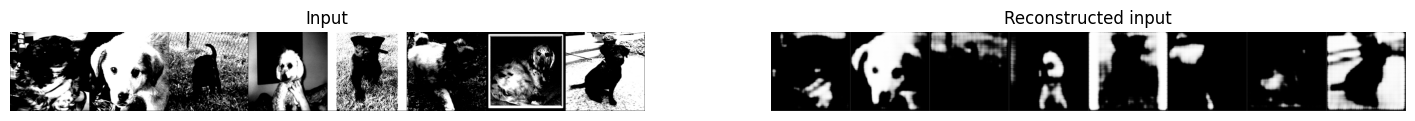

Epoch 1: 100%|██████████| 63/63 [00:46<00:00,  1.35batch/s]


======= Epoch: 1 Training loss: 0.0954 =======


100%|██████████| 13/13 [00:03<00:00,  3.69batch/s]


======= Test set loss: 0.1225 =======


Epoch 2: 100%|██████████| 63/63 [00:45<00:00,  1.37batch/s]


======= Epoch: 2 Training loss: 0.0947 =======


100%|██████████| 13/13 [00:03<00:00,  3.33batch/s]


======= Test set loss: 0.1166 =======


Epoch 3: 100%|██████████| 63/63 [00:45<00:00,  1.38batch/s]


======= Epoch: 3 Training loss: 0.0936 =======


100%|██████████| 13/13 [00:03<00:00,  3.67batch/s]


======= Test set loss: 0.1506 =======


Epoch 4: 100%|██████████| 63/63 [00:45<00:00,  1.38batch/s]


======= Epoch: 4 Training loss: 0.0945 =======


100%|██████████| 13/13 [00:03<00:00,  3.59batch/s]


======= Test set loss: 0.1208 =======


Epoch 5: 100%|██████████| 63/63 [00:45<00:00,  1.38batch/s]


======= Epoch: 5 Training loss: 0.0936 =======


100%|██████████| 13/13 [00:03<00:00,  3.55batch/s]


======= Test set loss: 0.1126 =======


Epoch 6: 100%|██████████| 63/63 [00:45<00:00,  1.38batch/s]


======= Epoch: 6 Training loss: 0.0935 =======


100%|██████████| 13/13 [00:03<00:00,  3.67batch/s]


======= Test set loss: 0.1250 =======


Epoch 7: 100%|██████████| 63/63 [00:45<00:00,  1.39batch/s]


======= Epoch: 7 Training loss: 0.0930 =======


100%|██████████| 13/13 [00:03<00:00,  3.33batch/s]


======= Test set loss: 0.1090 =======


Epoch 8: 100%|██████████| 63/63 [00:45<00:00,  1.39batch/s]


======= Epoch: 8 Training loss: 0.0929 =======


100%|██████████| 13/13 [00:03<00:00,  3.66batch/s]


======= Test set loss: 0.1128 =======


Epoch 9: 100%|██████████| 63/63 [00:45<00:00,  1.38batch/s]


======= Epoch: 9 Training loss: 0.0923 =======


100%|██████████| 13/13 [00:03<00:00,  3.41batch/s]


======= Test set loss: 0.1240 =======


Epoch 10: 100%|██████████| 63/63 [00:45<00:00,  1.39batch/s]


======= Epoch: 10 Training loss: 0.0929 =======


100%|██████████| 13/13 [00:03<00:00,  3.64batch/s]


======= Test set loss: 0.1037 =======


Epoch 11: 100%|██████████| 63/63 [00:45<00:00,  1.39batch/s]


======= Epoch: 11 Training loss: 0.0927 =======


100%|██████████| 13/13 [00:03<00:00,  3.57batch/s]


======= Test set loss: 0.1084 =======


Epoch 12: 100%|██████████| 63/63 [00:45<00:00,  1.40batch/s]


======= Epoch: 12 Training loss: 0.0924 =======


100%|██████████| 13/13 [00:03<00:00,  3.70batch/s]


======= Test set loss: 0.1151 =======


Epoch 13: 100%|██████████| 63/63 [00:45<00:00,  1.40batch/s]


======= Epoch: 13 Training loss: 0.0929 =======


100%|██████████| 13/13 [00:03<00:00,  3.65batch/s]


======= Test set loss: 0.1059 =======


Epoch 14: 100%|██████████| 63/63 [00:45<00:00,  1.40batch/s]


======= Epoch: 14 Training loss: 0.0917 =======


100%|██████████| 13/13 [00:03<00:00,  3.66batch/s]


======= Test set loss: 0.1119 =======


Epoch 15: 100%|██████████| 63/63 [00:44<00:00,  1.40batch/s]


======= Epoch: 15 Training loss: 0.0923 =======


100%|██████████| 13/13 [00:03<00:00,  3.67batch/s]


======= Test set loss: 0.1030 =======


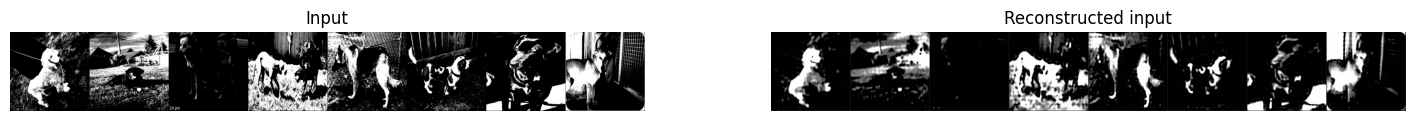

Epoch 16: 100%|██████████| 63/63 [00:44<00:00,  1.40batch/s]


======= Epoch: 16 Training loss: 0.0910 =======


100%|██████████| 13/13 [00:03<00:00,  3.30batch/s]


======= Test set loss: 0.1109 =======


Epoch 17: 100%|██████████| 63/63 [00:44<00:00,  1.40batch/s]


======= Epoch: 17 Training loss: 0.0918 =======


100%|██████████| 13/13 [00:03<00:00,  3.64batch/s]


======= Test set loss: 0.1152 =======


Epoch 18: 100%|██████████| 63/63 [00:44<00:00,  1.40batch/s]


======= Epoch: 18 Training loss: 0.0917 =======


100%|██████████| 13/13 [00:03<00:00,  3.39batch/s]


======= Test set loss: 0.1103 =======


Epoch 19: 100%|██████████| 63/63 [00:44<00:00,  1.41batch/s]


======= Epoch: 19 Training loss: 0.0915 =======


100%|██████████| 13/13 [00:03<00:00,  3.70batch/s]


======= Test set loss: 0.1096 =======


Epoch 20: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s]


======= Epoch: 20 Training loss: 0.0912 =======


100%|██████████| 13/13 [00:03<00:00,  3.37batch/s]


======= Test set loss: 0.1036 =======


Epoch 21: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s]


======= Epoch: 21 Training loss: 0.0920 =======


100%|██████████| 13/13 [00:03<00:00,  3.64batch/s]


======= Test set loss: 0.1152 =======


Epoch 22: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s]


======= Epoch: 22 Training loss: 0.0919 =======


100%|██████████| 13/13 [00:03<00:00,  3.37batch/s]


======= Test set loss: 0.1097 =======


Epoch 23: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


Epoch 00024: reducing learning rate of group 0 to 1.0000e-03.
======= Epoch: 23 Training loss: 0.0913 =======


100%|██████████| 13/13 [00:03<00:00,  3.68batch/s]


======= Test set loss: 0.1085 =======


Epoch 24: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


======= Epoch: 24 Training loss: 0.0909 =======


100%|██████████| 13/13 [00:03<00:00,  3.33batch/s]


======= Test set loss: 0.1044 =======


Epoch 25: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s]


======= Epoch: 25 Training loss: 0.0908 =======


100%|██████████| 13/13 [00:03<00:00,  3.66batch/s]


======= Test set loss: 0.1039 =======


Epoch 26: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


======= Epoch: 26 Training loss: 0.0910 =======


100%|██████████| 13/13 [00:03<00:00,  3.37batch/s]


======= Test set loss: 0.1029 =======


Epoch 27: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


======= Epoch: 27 Training loss: 0.0907 =======


100%|██████████| 13/13 [00:03<00:00,  3.64batch/s]


======= Test set loss: 0.0997 =======


Epoch 28: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


======= Epoch: 28 Training loss: 0.0908 =======


100%|██████████| 13/13 [00:03<00:00,  3.49batch/s]


======= Test set loss: 0.0995 =======


Epoch 29: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s]


======= Epoch: 29 Training loss: 0.0908 =======


100%|██████████| 13/13 [00:03<00:00,  3.65batch/s]


======= Test set loss: 0.1068 =======


Epoch 30: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


======= Epoch: 30 Training loss: 0.0906 =======


100%|██████████| 13/13 [00:03<00:00,  3.62batch/s]


======= Test set loss: 0.1042 =======


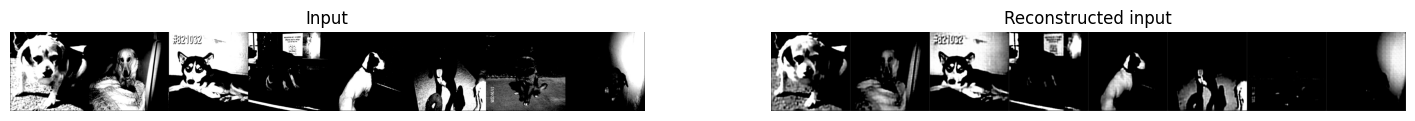

Epoch 31: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s]


======= Epoch: 31 Training loss: 0.0911 =======


100%|██████████| 13/13 [00:03<00:00,  3.62batch/s]


======= Test set loss: 0.1061 =======


Epoch 32: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


======= Epoch: 32 Training loss: 0.0905 =======


100%|██████████| 13/13 [00:03<00:00,  3.52batch/s]


======= Test set loss: 0.1084 =======


Epoch 33: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s]


======= Epoch: 33 Training loss: 0.0907 =======


100%|██████████| 13/13 [00:03<00:00,  3.67batch/s]


======= Test set loss: 0.1016 =======


Epoch 34: 100%|██████████| 63/63 [00:44<00:00,  1.41batch/s]


======= Epoch: 34 Training loss: 0.0908 =======


100%|██████████| 13/13 [00:03<00:00,  3.53batch/s]


======= Test set loss: 0.1022 =======


Epoch 35: 100%|██████████| 63/63 [00:44<00:00,  1.41batch/s]


======= Epoch: 35 Training loss: 0.0905 =======


100%|██████████| 13/13 [00:03<00:00,  3.65batch/s]


======= Test set loss: 0.1007 =======


Epoch 36: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s]


======= Epoch: 36 Training loss: 0.0903 =======


100%|██████████| 13/13 [00:03<00:00,  3.54batch/s]


======= Test set loss: 0.1031 =======


Epoch 37: 100%|██████████| 63/63 [00:44<00:00,  1.41batch/s]


======= Epoch: 37 Training loss: 0.0904 =======


100%|██████████| 13/13 [00:03<00:00,  3.54batch/s]


======= Test set loss: 0.1031 =======


Epoch 38: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s]


======= Epoch: 38 Training loss: 0.0906 =======


100%|██████████| 13/13 [00:03<00:00,  3.67batch/s]


======= Test set loss: 0.1053 =======


Epoch 39: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s]


======= Epoch: 39 Training loss: 0.0905 =======


100%|██████████| 13/13 [00:03<00:00,  3.45batch/s]


======= Test set loss: 0.1043 =======


Epoch 40: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


======= Epoch: 40 Training loss: 0.0905 =======


100%|██████████| 13/13 [00:03<00:00,  3.64batch/s]


======= Test set loss: 0.1052 =======


Epoch 41: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s]


======= Epoch: 41 Training loss: 0.0906 =======


100%|██████████| 13/13 [00:03<00:00,  3.37batch/s]


======= Test set loss: 0.1025 =======


Epoch 42: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


======= Epoch: 42 Training loss: 0.0908 =======


100%|██████████| 13/13 [00:03<00:00,  3.69batch/s]


======= Test set loss: 0.1092 =======


Epoch 43: 100%|██████████| 63/63 [00:43<00:00,  1.43batch/s]


======= Epoch: 43 Training loss: 0.0902 =======


100%|██████████| 13/13 [00:03<00:00,  3.35batch/s]


======= Test set loss: 0.1017 =======


Epoch 44: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


======= Epoch: 44 Training loss: 0.0903 =======


100%|██████████| 13/13 [00:03<00:00,  3.62batch/s]


======= Test set loss: 0.1008 =======


Epoch 45: 100%|██████████| 63/63 [00:43<00:00,  1.43batch/s]


======= Epoch: 45 Training loss: 0.0905 =======


100%|██████████| 13/13 [00:03<00:00,  3.33batch/s]


======= Test set loss: 0.1074 =======


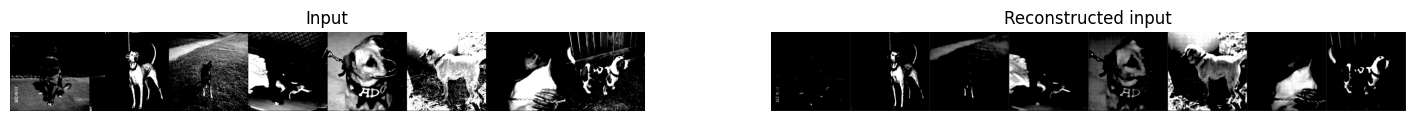

Epoch 46: 100%|██████████| 63/63 [00:43<00:00,  1.43batch/s]


======= Epoch: 46 Training loss: 0.0905 =======


100%|██████████| 13/13 [00:03<00:00,  3.61batch/s]


======= Test set loss: 0.0977 =======


Epoch 47: 100%|██████████| 63/63 [00:43<00:00,  1.43batch/s]


======= Epoch: 47 Training loss: 0.0902 =======


100%|██████████| 13/13 [00:03<00:00,  3.32batch/s]


======= Test set loss: 0.1074 =======


Epoch 48: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 48 Training loss: 0.0905 =======


100%|██████████| 13/13 [00:03<00:00,  3.67batch/s]


======= Test set loss: 0.1025 =======


Epoch 49: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 49 Training loss: 0.0902 =======


100%|██████████| 13/13 [00:03<00:00,  3.44batch/s]


======= Test set loss: 0.1086 =======


Epoch 50: 100%|██████████| 63/63 [00:43<00:00,  1.43batch/s]


======= Epoch: 50 Training loss: 0.0903 =======


100%|██████████| 13/13 [00:03<00:00,  3.65batch/s]


======= Test set loss: 0.1059 =======


Epoch 51: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 51 Training loss: 0.0906 =======


100%|██████████| 13/13 [00:03<00:00,  3.54batch/s]


======= Test set loss: 0.1084 =======


Epoch 52: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


======= Epoch: 52 Training loss: 0.0903 =======


100%|██████████| 13/13 [00:03<00:00,  3.66batch/s]


======= Test set loss: 0.1089 =======


Epoch 53: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 53 Training loss: 0.0904 =======


100%|██████████| 13/13 [00:03<00:00,  3.67batch/s]


======= Test set loss: 0.1009 =======


Epoch 54: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 54 Training loss: 0.0902 =======


100%|██████████| 13/13 [00:03<00:00,  3.50batch/s]


======= Test set loss: 0.1042 =======


Epoch 55: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 55 Training loss: 0.0903 =======


100%|██████████| 13/13 [00:03<00:00,  3.70batch/s]


======= Test set loss: 0.1027 =======


Epoch 56: 100%|██████████| 63/63 [00:43<00:00,  1.45batch/s]


Epoch 00057: reducing learning rate of group 0 to 2.0000e-04.
======= Epoch: 56 Training loss: 0.0905 =======


100%|██████████| 13/13 [00:03<00:00,  3.32batch/s]


======= Test set loss: 0.1054 =======


Epoch 57: 100%|██████████| 63/63 [00:43<00:00,  1.45batch/s]


======= Epoch: 57 Training loss: 0.0900 =======


100%|██████████| 13/13 [00:03<00:00,  3.67batch/s]


======= Test set loss: 0.1046 =======


Epoch 58: 100%|██████████| 63/63 [00:43<00:00,  1.45batch/s]


======= Epoch: 58 Training loss: 0.0903 =======


100%|██████████| 13/13 [00:03<00:00,  3.41batch/s]


======= Test set loss: 0.1015 =======


Epoch 59: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 59 Training loss: 0.0902 =======


100%|██████████| 13/13 [00:03<00:00,  3.71batch/s]


======= Test set loss: 0.1022 =======


Epoch 60: 100%|██████████| 63/63 [00:43<00:00,  1.45batch/s]


======= Epoch: 60 Training loss: 0.0901 =======


100%|██████████| 13/13 [00:03<00:00,  3.63batch/s]


======= Test set loss: 0.1021 =======


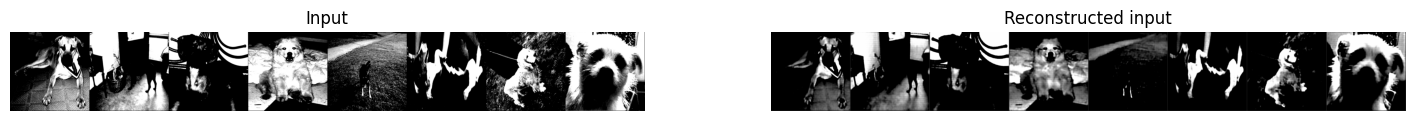

Epoch 61: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 61 Training loss: 0.0897 =======


100%|██████████| 13/13 [00:03<00:00,  3.66batch/s]


======= Test set loss: 0.1043 =======


Epoch 62: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 62 Training loss: 0.0898 =======


100%|██████████| 13/13 [00:03<00:00,  3.54batch/s]


======= Test set loss: 0.1021 =======


Epoch 63: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s]


======= Epoch: 63 Training loss: 0.0902 =======


100%|██████████| 13/13 [00:03<00:00,  3.60batch/s]


======= Test set loss: 0.1013 =======


Epoch 64: 100%|██████████| 63/63 [00:43<00:00,  1.45batch/s]


======= Epoch: 64 Training loss: 0.0897 =======


100%|██████████| 13/13 [00:03<00:00,  3.73batch/s]


======= Test set loss: 0.1034 =======


Epoch 65: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 65 Training loss: 0.0895 =======


100%|██████████| 13/13 [00:03<00:00,  3.44batch/s]


======= Test set loss: 0.1031 =======


Epoch 66: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 66 Training loss: 0.0897 =======


100%|██████████| 13/13 [00:03<00:00,  3.65batch/s]


======= Test set loss: 0.1012 =======


Epoch 67: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 67 Training loss: 0.0901 =======


100%|██████████| 13/13 [00:04<00:00,  3.23batch/s]


======= Test set loss: 0.1009 =======


Epoch 68: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s]


======= Epoch: 68 Training loss: 0.0899 =======


100%|██████████| 13/13 [00:03<00:00,  3.69batch/s]

======= Test set loss: 0.1029 =======
We had no futher improvement. So, early stopping happened.


In [ ]:
epochs = 251

train_loss_list = []                                             # a list to save train lost during training
test_loss_list = []                                              # a list to save test lost during training

early_stopper = EarlyStopper(patience=22, min_delta=0.0002)      #our early stopper class

for epoch in range(epochs):
    ### =====TRAINING=====
    model.train()
    train_loss = 0
    with tqdm(train_loader, unit="batch") as train_epoch_pbar:   #tqdm used for demonstarion of training and results
        for datas, labels in train_epoch_pbar:                   #importing data from dataloader
            train_epoch_pbar.set_description(f"Epoch {epoch}")   #for demonstartion

            # moving data to GPU computation if availabe
            datas = datas.to(device)

            """
            We zero gradient because if we keep it, its information will somewhat become outdated.
            When we import new batches, we have new data and there is no reason that the gradiant
            direction towards optimum remains the same as before.
            """
            optimizer.zero_grad()

            # forwad pass for batch of data
            outputs = model(datas)

            #computing loss function for batch
            loss = criterion(outputs, datas)

            #backpropagation for batch
            loss.backward()
            optimizer.step()

            #computing epoch loss
            train_loss += loss.item()

        #normalize epoch loss
        train_loss /= len(train_loader.dataset)

        #learning rate scheduler based on train_loss
        scheduler.step(train_loss)

        print(
            f"======= Epoch: {epoch} Training loss: {train_loss:.4f} ======="
        )
        train_loss_list.append(train_loss)                         #storing train losses in a list

    ### =====TESTING=====
    model.eval()
    test_loss = 0
    with torch.no_grad():                         #As we want to evaluate model, no learning happens. So, no_grad
        with tqdm(test_loader, unit="batch") as test_pbar:         #use tqdm for showing results
            for datas, labels in test_pbar:                        #importing data from test loader
                datas = datas.to(device)                           #moving data to GPU if available

                #feeding network forward by batches of data
                outputs = model(datas)

                #computing batch loss
                loss = criterion(outputs, datas)

                #computing epoch loss
                test_loss += loss.item()

    #normalizing epoch test loss
    test_loss /= len(test_loader.dataset)
    print(f"======= Test set loss: {test_loss:.4f} =======")
    test_loss_list.append(test_loss)                              #storing epochs test losses in a list

    #Early Stopper on test set
    if early_stopper.early_stop(test_loss):
        print('We had no futher improvement. So, early stopping happened.')
        break


    # Visualizing training progress: To make document smaller in size, it will only show results after each 15 epochs
    if epoch % 15==0:
        visualiz(test_loader)

Text(0.5, 1.0, 'MSE loss')

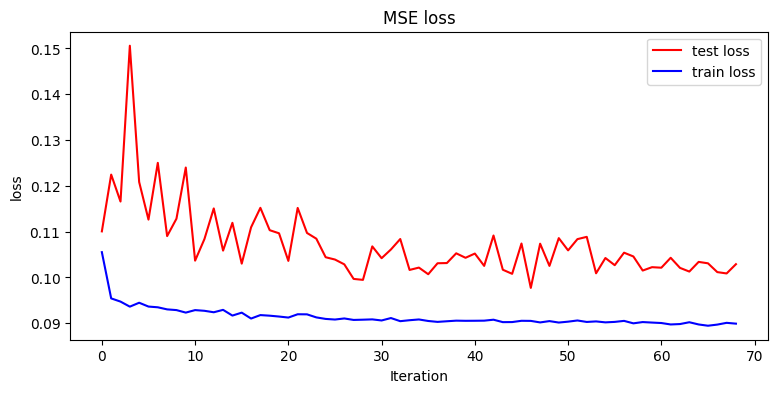

In [ ]:
#A figure showing test and train loss during training.
plt.figure(figsize= (9,4))
plt.plot(test_loss_list, color='red', label="test loss")
plt.plot(train_loss_list, color='blue', label= 'train loss')
plt.legend(loc="upper right")
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('MSE loss')

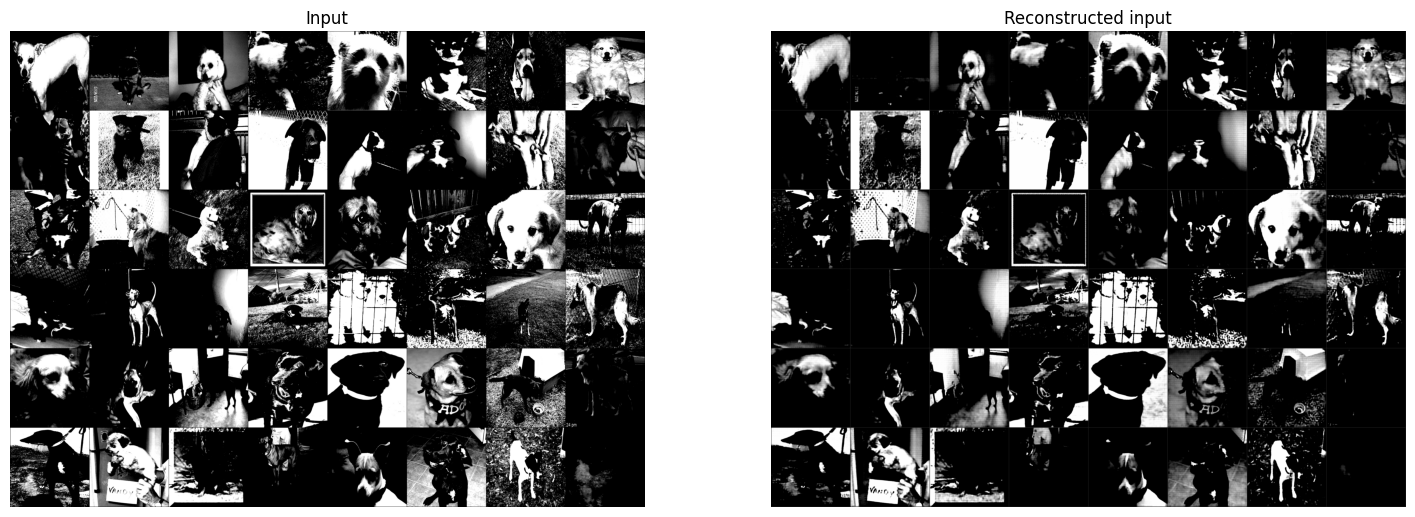

In [ ]:
#Visualizing input data and its reconstruction by using our final model.

#a data loader that calls randomly 48 images from test loader.
valid_loader= torch.utils.data.DataLoader(test_ds, batch_size= 48, shuffle= True)

f, axarr = plt.subplots(1, 2, figsize=(18, 18))

with torch.no_grad():
    x, _ = next(iter(valid_loader))
    x = x.to(device)
    outputs = model(x)
    x_out = outputs.detach().cpu()             #we need to bring images to cpu for showing
    x = x.detach().cpu()                       #we need to bring images to cpu for showing

    image_grid = make_grid(x.view(48, 1, 600, 600), nrow=8).permute(1, 2, 0)
    axarr[0].imshow(image_grid.numpy())
    axarr[0].set_title("Input")
    axarr[0].axis("off")

    image_grid = make_grid(x_out.view(48, 1, 600, 600), nrow=8).permute(1, 2, 0)
    axarr[1].imshow(image_grid.numpy())
    axarr[1].set_title("Reconstructed input")
    axarr[1].axis("off")

As I saved best model parameters as "best", I also demonstrate a reconstruction results on our best model. As our best model is not significantly better than our final model, clearly its performance on reconstructing data is not much better than final model. But, it is still, a little better.

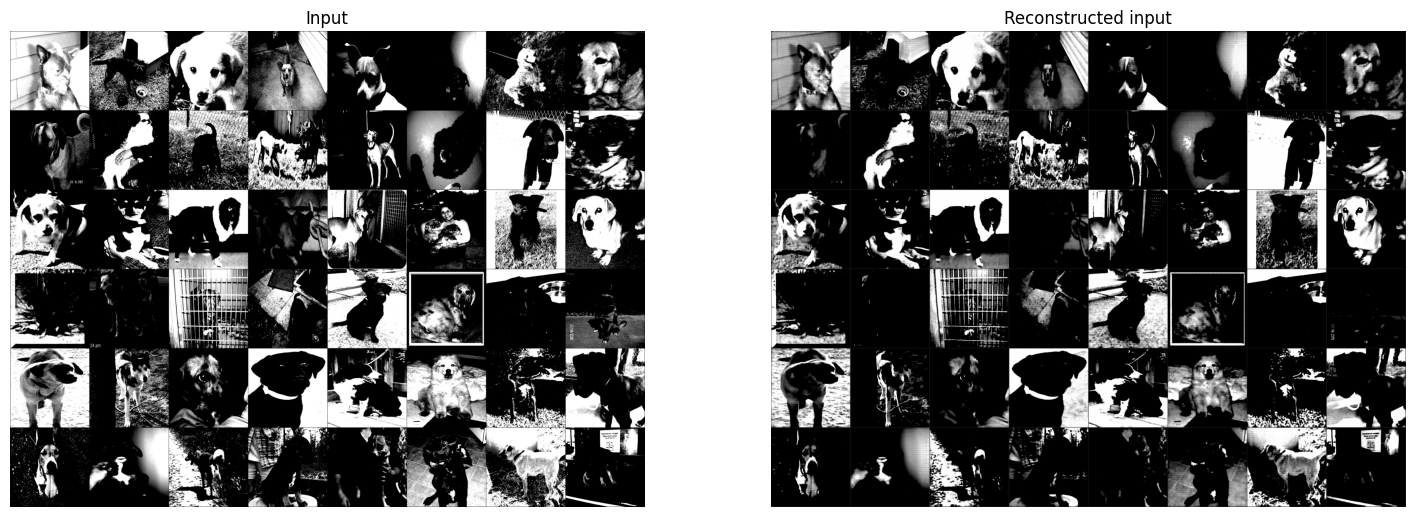

In [ ]:
#Visualizing input data and its reconstruction by using our "best" model

valid_loader= torch.utils.data.DataLoader(test_ds, batch_size= 48, shuffle= True)

f, axarr = plt.subplots(1, 2, figsize=(18, 18))

with torch.no_grad():
    x, _ = next(iter(valid_loader))
    x = x.to(device)
    outputs = best(x)
    x_out = outputs.detach().cpu()
    x = x.detach().cpu()

    image_grid = make_grid(x.view(48, 1, 600, 600), nrow=8).permute(1, 2, 0)
    axarr[0].imshow(image_grid.numpy())
    axarr[0].set_title("Input")
    axarr[0].axis("off")

    image_grid = make_grid(x_out.view(48, 1, 600, 600), nrow=8).permute(1, 2, 0)
    axarr[1].imshow(image_grid.numpy())
    axarr[1].set_title("Reconstructed input")
    axarr[1].axis("off")